In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from scipy import sparse
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.callbacks import EarlyStopping
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Memuat Data
X_embed = sparse.load_npz('/content/drive/My Drive/Revisi/X_tfidf.npz')  # fitur TF-IDF
y_labels = np.load('/content/drive/My Drive/Revisi/y_tfidf.npy', allow_pickle=True)  # Label yang sesuai

In [ ]:
# 2. Encode Labels (jika label masih dalam bentuk teks)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_labels)

In [ ]:
y_encoded

array([0, 1, 0, ..., 2, 0, 0])

In [ ]:
print(len(y_encoded))

10229


In [ ]:
# 3. Membagi Data menjadi Train dan Test
X_train, X_test, y_train, y_test = train_test_split(X_embed, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Menampilkan sebagian isi X_train dan y_train
print("Data X_train:")
print(X_train[:5])  # Menampilkan 5 data pertama
print("\nLabel y_train:")
print(y_train[:5])

print("\nData X_test:")
print(X_test[:5])  # Menampilkan 5 data pertama
print("\nLabel y_test:")
print(y_test[:5])

print("Jumlah data training:", X_train.shape[0])
print("Jumlah data testing :", X_test.shape[0])

Data X_train:
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 160 stored elements and shape (5, 5000)>
  Coords	Values
  (0, 2507)	0.051332708209141736
  (0, 3440)	0.08007111803612932
  (0, 3330)	0.06386622588981034
  (0, 4271)	0.09318396026688006
  (0, 3383)	0.09330963231909574
  (0, 178)	0.1964422192387191
  (0, 4783)	0.15187698859955148
  (0, 1779)	0.17857979611144853
  (0, 4539)	0.20587261890783873
  (0, 1617)	0.22323253550407823
  (0, 1971)	0.09041490518869781
  (0, 2648)	0.15394381407331298
  (0, 3055)	0.18812555930266428
  (0, 1979)	0.10800705549482655
  (0, 3197)	0.1484767543749592
  (0, 4796)	0.24708427989061296
  (0, 3462)	0.17328197279866184
  (0, 3203)	0.18490096481826604
  (0, 4593)	0.2137596823873259
  (0, 287)	0.1995864749357671
  (0, 2813)	0.2479651056385125
  (0, 3061)	0.2909591453194136
  (0, 4385)	0.2835202066275441
  (0, 3011)	0.2835202066275441
  (0, 4386)	0.2835202066275441
  :	:
  (4, 1027)	0.3017963260505094
  (4, 4928)	0.14961089974608768
  (4, 13

In [ ]:
# 2. Oversampling menggunakan RandomOverSampler
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
# Inisialisasi EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

In [ ]:
# 4. Membangun Model LSTM
model = Sequential([

    # preprocessing layer
    tf.keras.layers.Reshape((1, X_embed.shape[1])),

    # LSTM layer
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    GlobalMaxPooling1D(),

    # fully connected layer
    Dense(64, activation='relu'),
    Dropout(0.5),

    # Output Layer (3 kelas: Positif, Negatif, Netral)
    Dense(3, activation='softmax')
])

In [ ]:
# 5. Kompilasi Model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_resampled, y_resampled,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 156ms/step - accuracy: 0.5066 - loss: 0.9841 - val_accuracy: 0.7761 - val_loss: 0.5894
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 133ms/step - accuracy: 0.7986 - loss: 0.5204 - val_accuracy: 0.8574 - val_loss: 0.4142
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 144ms/step - accuracy: 0.8472 - loss: 0.4076 - val_accuracy: 0.9020 - val_loss: 0.2986
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.8669 - loss: 0.3569 - val_accuracy: 0.9139 - val_loss: 0.2741
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 147ms/step - accuracy: 0.8696 - loss: 0.3431 - val_accuracy: 0.9295 - val_loss: 0.2480
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 202ms/step - accuracy: 0.8820 - loss: 0.3107 - val_accuracy: 0.9430 - val_loss: 0.2053
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.8905 - loss: 0.2851 - val_accuracy: 0.9546 - val_loss: 0.1803
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.9056 - loss: 0

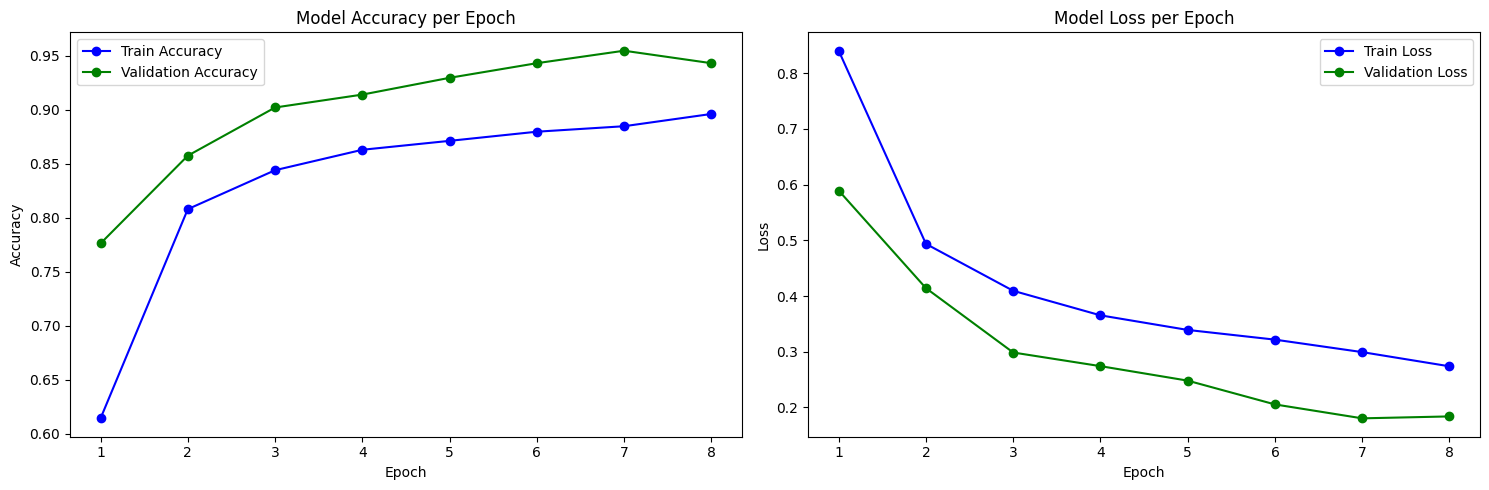

In [ ]:
# Ambil nilai dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))

# Grafik Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'go-', label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()

# Grafik Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Train Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 7. Evaluasi Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8445 - loss: 0.4711
Test Accuracy: 0.84


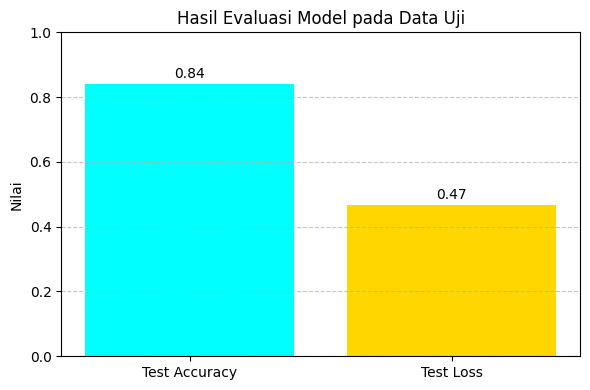

In [ ]:
# Visualisasi hasil evaluasi
metrics = ['Test Accuracy', 'Test Loss']
values = [test_accuracy, test_loss]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['cyan', 'gold'])

# Tampilkan nilai di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.ylim(0, 1)  # skala 0–1
plt.title('Hasil Evaluasi Model pada Data Uji')
plt.ylabel('Nilai')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step


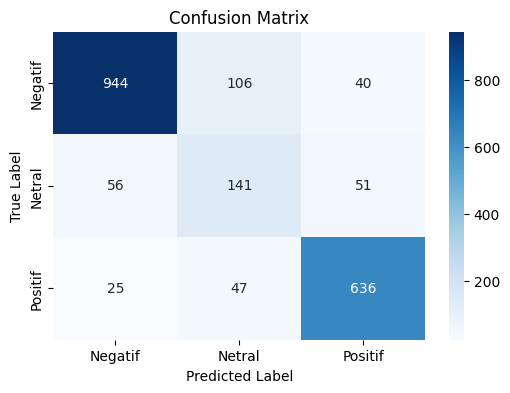

              precision    recall  f1-score   support

     Negatif       0.92      0.87      0.89      1090
      Netral       0.48      0.57      0.52       248
     Positif       0.87      0.90      0.89       708

    accuracy                           0.84      2046
   macro avg       0.76      0.78      0.77      2046
weighted avg       0.85      0.84      0.85      2046



In [ ]:
# Prediksi
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

# Gunakan langsung y_test (karena sudah label numerik, bukan one-hot)
y_true = y_test

# Evaluasi
labels = ["Negatif", "Netral", "Positif"]
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred_labels, target_names=labels))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print(f"Akurasi: {accuracy_score(y_true, y_pred_labels):.4f}\n")
print("\nConfusion Matrix:")
print("       Pred_" + "  Pred_".join(labels))
for i, row in enumerate(cm):
    print(f"{labels[i]:7}", end=" ")
    for val in row:
        print(f"{val:9}", end=" ")
    print()

Akurasi: 0.8412


Confusion Matrix:
       Pred_Negatif  Pred_Netral  Pred_Positif
Negatif       944       106        40 
Netral         56       141        51 
Positif        25        47       636 


Negatif: 1025 data (50.10%)
Netral: 294 data (14.37%)
Positif: 727 data (35.53%)


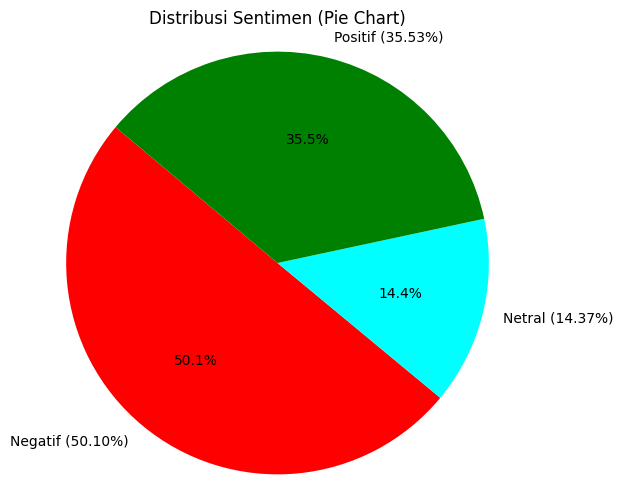

In [ ]:
# Daftar label sentimen
labels = ["Negatif", "Netral", "Positif"]

# Misalnya y_pred_labels adalah hasil prediksi
kelas, jumlah = np.unique(y_pred_labels, return_counts=True)
total = sum(jumlah)
persentase = [(j / total) * 100 for j in jumlah]

# Tampilkan jumlah dan persentase per kelas
for i, (k, j) in enumerate(zip(kelas, jumlah)):
    print(f"{labels[k]}: {j} data ({persentase[i]:.2f}%)")

# ===== PIE CHART =====
label_persen = [f"{labels[k]} ({persentase[i]:.2f}%)" for i, k in enumerate(kelas)]

plt.figure(figsize=(6, 6))
plt.pie(jumlah, labels=label_persen, autopct='%1.1f%%', startangle=140, colors=['red','cyan','green'])
plt.title("Distribusi Sentimen (Pie Chart)")
plt.axis('equal')  # Agar lingkaran tidak oval
plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical

y_test_oh = to_categorical(y_test, num_classes=3)  # asumsi 3 kelas


# y_pred = model.predict(X_test) sudah diasumsikan tersedia
fpr = {}
tpr = {}
roc_auc = {}
n_classes = 3
labels = ["Negatif", "Netral", "Positif"]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_oh[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


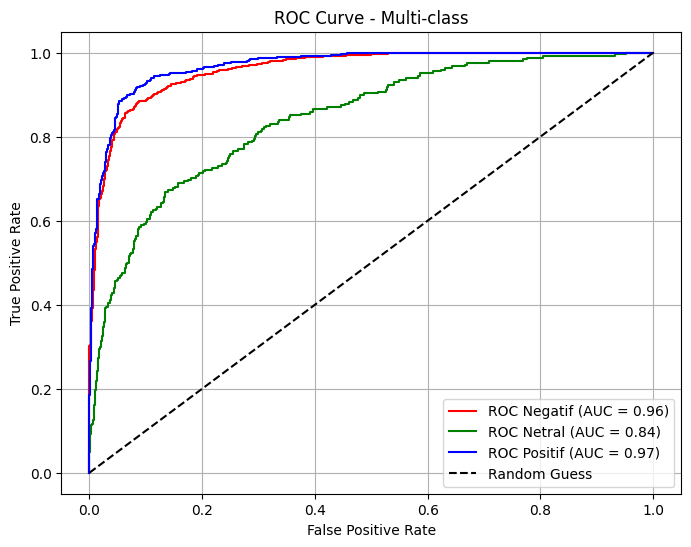

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"ROC {labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
model.save("sentimen_analisis.h5")

In [ ]:
model = load_model("sentimen_analisis.h5")

In [ ]:
# Baca data uji (data baru yang ingin diprediksi)
df_datauji = pd.read_excel('/content/drive/MyDrive/TugasAkhir/datauji.xlsx')
data_uji = df_datauji['text'].tolist()

tfidf_vectorizer = joblib.load('/content/drive/MyDrive/Bert_TFIDF/tfidf_vectorizer.pkl')

# Ubah teks menjadi fitur menggunakan TF-IDF
X_uji = tfidf_vectorizer.transform(data_uji)

# Prediksi probabilitas per kelas
y_pred = model.predict(X_uji)

y_true = df_datauji['label'].tolist()
le = LabelEncoder()
y_true_datauji_encoded = le.fit_transform(y_true)

# Ambil label prediksi (kelas dengan probabilitas tertinggi)
y_pred_label = y_pred.argmax(axis=1)

# Map label angka ke string
label_map = {0: "Negatif", 1: "Netral", 2: "Positif"}
predicted_labels = [label_map[label] for label in y_pred_label]

# Tampilkan prediksi per teks
print("Prediksi per teks:")
for teks, label_pred in zip(data_uji, predicted_labels):
    print(f"Teks: {teks}\nLabel Prediksi: {label_pred}\n")

# Hitung dan tampilkan ringkasan distribusi label
unique, counts = np.unique(y_pred_label, return_counts=True)
total_data = sum(counts)
print("Ringkasan Kecenderungan Sentimen:")
for label, count in zip(unique, counts):
    persen = (count / total_data) * 100
    print(f"{label_map[label]}: {count} data ({persen:.2f}%)")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
Prediksi per teks:
Teks: pemilihan menteri kali ini menunjukkan keberanian presiden dalam membawa wajah baru pemerintahan.
Label Prediksi: Netral

Teks: langkah cerdas memilih figur yang sudah terbukti berdampak di masyarakat.
Label Prediksi: Negatif

Teks:  langkah memilih teknokrat menunjukkan fokus pada hasil nyata.
Label Prediksi: Positif

Teks: masyarakat menyambut antusias para menteri baru yang punya visi kuat.
Label Prediksi: Positif

Teks: presiden berhasil menyusun kabinet yang seimbang antara senioritas dan inovasi.
Label Prediksi: Negatif

Teks: menteri baru bidang pendidikan sangat visioner dan progresif.
Label Prediksi: Positif

Teks: penunjukan menteri dari kalangan profesional menunjukkan arah reformasi birokrasi.
Label Prediksi: Netral

Teks: penunjukan menteri baru di bidang ekonomi menunjukkan keberanian dalam menghadapi tantangan global.
Label Prediksi: Positif

Teks: kabinet baru harapan baru.
Label Prediksi: Positif

Teks: se

In [ ]:
print(f"Jumlah data uji (input_tfidf): {X_uji.shape[0]}")
print(f"Jumlah label y_true_datauji_encoded: {len(y_pred_label)}")

Jumlah data uji (input_tfidf): 60
Jumlah label y_true_datauji_encoded: 60


In [ ]:
print("Unique label dan jumlah masing-masing:")
print(df_datauji['label'].value_counts())

Unique label dan jumlah masing-masing:
label
negatif    22
netral     20
positif    18
Name: count, dtype: int64



Akurasi: 0.4000



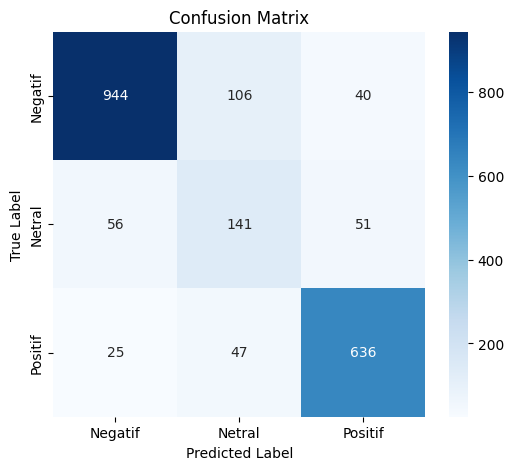

Classification Report:
              precision    recall  f1-score   support

     negatif       0.50      0.41      0.45        22
      netral       0.46      0.30      0.36        20
     positif       0.31      0.50      0.38        18

    accuracy                           0.40        60
   macro avg       0.42      0.40      0.40        60
weighted avg       0.43      0.40      0.40        60


Confusion Matrix:
       Pred_negatif  Pred_netral  Pred_positif
negatif         9         2        11 
netral          5         6         9 
positif         4         5         9 


In [ ]:
# Evaluasi
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Evaluasi Akurasi
print(f"\nAkurasi: {accuracy_score(y_true_datauji_encoded, y_pred_label):.4f}\n")

# Visualisasi Confusion Matrix sebagai heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true_datauji_encoded, y_pred_label, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true_datauji_encoded, y_pred_label)
labels = le.classes_

print("\nConfusion Matrix:")
print("       Pred_" + "  Pred_".join(labels))
for i, row in enumerate(cm):
    print(f"{labels[i]:7}", end=" ")
    for val in row:
        print(f"{val:9}", end=" ")
    print()